# Mamba Causal Tracing: Three Restoration Strategies

This notebook demonstrates three different causal tracing strategies for Mamba State Space Models:

1. **Per-Position Restoration** - Restore individual (layer, position) pairs
2. **Per-Layer Restoration** - Restore all positions in a layer at once
3. **Per-Timestep Restoration** - Restore all layers at a specific timestep

Each strategy answers a different question about where factual knowledge is stored and processed in Mamba.

## Setup

In [1]:
# Imports
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mamba_causal_analysis.mamba_models import load_mamba_model
from mamba_causal_analysis.mamba_causal_trace import calculate_hidden_flow

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Imports successful
PyTorch version: 2.4.1+cu121
CUDA available: True


In [2]:
# Load model
model_name = "state-spaces/mamba-130m"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading {model_name}...")
mt = load_mamba_model(model_name, device=device)
print(f"✓ Model loaded with {mt.num_layers} layers")
print(f"  Device: {mt.device}")

Loading state-spaces/mamba-130m...
Loading Mamba model: state-spaces/mamba-130m


/Users/ajbailey4@ad.wisc.edu/mamba-causal-analysis/.venv/lib/python3.10/site-packages/mamba_ssm/utils/hf.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.lo

Identified 24 Mamba layers
✓ Model loaded with 24 layers
  Device: cuda


In [3]:
# Define test prompt
test_cases = [
    {"prompt": "The Eiffel Tower is located in", "subject": "Eiffel Tower"},
    {"prompt": "The Space Needle is located in downtown", "subject": "Space Needle"},
    {"prompt": "The mother tongue of Angela Merkel is", "subject": "Angela Merkel"},
    {"prompt": "Apple Inc. was founded by Steve", "subject": "Apple Inc"},
]

# Select test case
test = test_cases[0]
prompt = test["prompt"]
subject = test["subject"]

print(f"Prompt: \"{prompt}\"")
print(f"Subject: \"{subject}\"")
print()

# Test model predictions
tokens = mt.tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = mt.model(tokens["input_ids"])
    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
    probs = torch.softmax(logits[0, -1, :], dim=0)
    top_tokens = torch.topk(probs, 5)
    
print("Model's top 5 predictions:")
for prob, token_id in zip(top_tokens.values, top_tokens.indices):
    token_str = mt.tokenizer.decode([token_id.item()])
    print(f"  {token_str:20s} {prob.item():.4f}")

# Common parameters
samples = 10
noise_level = 3.0

Prompt: "The Eiffel Tower is located in"
Subject: "Eiffel Tower"

Model's top 5 predictions:
   Paris               0.5299
   the                 0.2801
   France              0.0180
   New                 0.0158
   Vers                0.0094


---
## Strategy 1: Per-Position Restoration

**Question:** Which specific (layer, position) pairs are critical?

**Method:** For each (layer, position) pair, restore only that specific hidden state.

**Output:** 2D heatmap [layers × positions]

In [4]:
print("=" * 60)
print("STRATEGY 1: PER-POSITION RESTORATION")
print("=" * 60)
print(f"Testing each (layer, position) pair individually")
print(f"Tracing {mt.num_layers} layers × sequence length positions")
print()

result_per_position = calculate_hidden_flow(
    mt,
    mt.tokenizer,
    prompt=prompt,
    subject=subject,
    samples=samples,
    noise_level=noise_level,
    mode="per_position",
)

print(f"✓ Complete!")
print(f"  Clean: {result_per_position['high_score']:.4f}")
print(f"  Corrupted: {result_per_position['low_score']:.4f}")
print(f"  Score matrix shape: {result_per_position['scores'].shape}")

STRATEGY 1: PER-POSITION RESTORATION
Testing each (layer, position) pair individually
Tracing 24 layers × sequence length positions

Tracing 24 layers x 8 positions (per-position mode)...
  Completed layer 5/24
  Completed layer 10/24
  Completed layer 15/24
  Completed layer 20/24
✓ Complete!
  Clean: 0.5299
  Corrupted: 0.0007
  Score matrix shape: (24, 8)


In [6]:
# Run causal tracing - COMPARING MIXER OUTPUT vs RECURRENT STATE RESTORATION

# Import the new simplified API
from mamba_causal_analysis.mamba_causal_trace_v2 import trace_important_states

samples = 10  # Number of noise samples (10 for full run, 3 for quick testing)
noise_level = 3.0  # Standard deviations of noise (ROME standard)

print("="*70)
print("CAUSAL TRACING: MIXER OUTPUT vs RECURRENT STATE COMPARISON")
print("="*70)
print(f"Prompt: \"{prompt}\"")
print(f"Subject to corrupt: '{subject}'")
print(f"Samples per experiment: {samples}")
print()

# EXPERIMENT 1: Mixer Output Restoration (what goes into residual stream)
print("="*70)
print("EXPERIMENT 1: MIXER OUTPUT RESTORATION")
print("="*70)
print("This restores the mixer output (what gets added to the residual stream)")
print()

print("1b. Per-Position Granularity (restore specific layer×position pairs)")
result_mixer_per_position = trace_important_states(
    mt,
    mt.tokenizer,
    prompt=prompt,
    subject=subject,
    component='mixer_output',
    granularity='per_position',
    samples=samples,
    noise_level=noise_level,
)
print()

# EXPERIMENT 2: Recurrent State Restoration (SSM internal cache)
print("="*70)
print("EXPERIMENT 2: RECURRENT STATE RESTORATION")
print("="*70)
print("This restores the SSM's internal recurrent states (conv_state, ssm_state)")
print("WARNING: This is SLOW due to token-by-token processing")
print()

RUN_RECURRENT_STATE = True  # Set to False to skip (saves ~15-30 min)

if RUN_RECURRENT_STATE:
    print("2b. Per-Position Granularity (restore SSM states at specific layer×position pairs)")
    result_recurrent_per_position = trace_important_states(
        mt,
        mt.tokenizer,
        prompt=prompt,
        subject=subject,
        component='recurrent_state',
        granularity='per_position',
        samples=samples,
        noise_level=noise_level,
    )
    print()
else:
    print("SKIPPED (set RUN_RECURRENT_STATE = True to enable)")
    print("Estimated time: 15-30 minutes with samples=10")
    result_recurrent_per_layer = None
    result_recurrent_per_position = None
    print()

print("="*70)
print("ALL EXPERIMENTS COMPLETE")
print("="*70)

CAUSAL TRACING: MIXER OUTPUT vs RECURRENT STATE COMPARISON
Prompt: "The Eiffel Tower is located in"
Subject to corrupt: 'Eiffel Tower'
Samples per experiment: 10

EXPERIMENT 1: MIXER OUTPUT RESTORATION
This restores the mixer output (what gets added to the residual stream)

1b. Per-Position Granularity (restore specific layer×position pairs)
Causal Tracing: component=mixer_output, granularity=per_position
  Clean probability: 0.5299 for ' Paris'
  Subject: 'Eiffel Tower' at positions 2-4
Tracing 24 layers × 8 positions...


ValueError: Must provide either clean_states or clean_input_ids

---
## Strategy 2: Per-Layer Restoration

**Question:** Which layers are most critical for the output?

**Method:** For each layer, restore ALL positions in that layer simultaneously.

**Output:** 1D array [layers]

**Note:** This works because our hooks process the full sequence after it passes through each layer.

In [34]:
print("=" * 60)
print("STRATEGY 2: PER-LAYER RESTORATION")
print("=" * 60)
print(f"Restoring all positions in each layer")
print(f"Tracing {mt.num_layers} layers")
print()

result_per_layer = calculate_hidden_flow(
    mt,
    mt.tokenizer,
    prompt=prompt,
    subject=subject,
    samples=samples,
    noise_level=noise_level,
    mode="per_layer",
)

print(f"✓ Complete!")
print(f"  Clean: {result_per_layer['high_score']:.4f}")
print(f"  Corrupted: {result_per_layer['low_score']:.4f}")
print(f"  Score array shape: {result_per_layer['scores'].shape}")

STRATEGY 2: PER-LAYER RESTORATION
Restoring all positions in each layer
Tracing 24 layers

Tracing 24 layers (per-layer mode)...
  Completed layer 5/24
  Completed layer 10/24
  Completed layer 15/24
  Completed layer 20/24
✓ Complete!
  Clean: 0.5299
  Corrupted: 0.0010
  Score array shape: (24,)


In [ ]:
# Visualize: Per-Layer Comparison (Mixer Output vs Recurrent State)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Mixer Output Per-Layer
ax1 = axes[0]
ax1.plot(result_mixer_per_layer['scores'], marker='o', linewidth=2, markersize=8, 
         label='Layer restoration', color='steelblue')
ax1.axhline(result_mixer_per_layer['low_score'], color='red', linestyle='--', 
            label='Corrupted baseline', alpha=0.7, linewidth=2)
ax1.axhline(result_mixer_per_layer['high_score'], color='green', linestyle='--', 
            label='Clean baseline', alpha=0.7, linewidth=2)
ax1.set_xlabel('Layer', fontsize=12)
ax1.set_ylabel('Probability of Correct Answer', fontsize=12)
ax1.set_title('Mixer Output Restoration\n(Per-Layer)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Find and mark best layer
best_layer_mixer = result_mixer_per_layer['scores'].argmax()
ax1.plot(best_layer_mixer, result_mixer_per_layer['scores'][best_layer_mixer], 
         'r*', markersize=15, markeredgecolor='darkred', markeredgewidth=1.5)
ax1.text(best_layer_mixer, result_mixer_per_layer['scores'][best_layer_mixer], 
         f'  Layer {best_layer_mixer}', fontsize=10, va='bottom')

# Plot 2: Recurrent State Per-Layer (if available)
ax2 = axes[1]
if result_recurrent_per_layer is not None:
    ax2.plot(result_recurrent_per_layer['scores'], marker='o', linewidth=2, markersize=8, 
             label='Layer restoration', color='darkorange')
    ax2.axhline(result_recurrent_per_layer['low_score'], color='red', linestyle='--', 
                label='Corrupted baseline', alpha=0.7, linewidth=2)
    ax2.axhline(result_recurrent_per_layer['high_score'], color='green', linestyle='--', 
                label='Clean baseline', alpha=0.7, linewidth=2)
    ax2.set_xlabel('Layer', fontsize=12)
    ax2.set_ylabel('Probability of Correct Answer', fontsize=12)
    ax2.set_title('Recurrent State Restoration\n(Per-Layer)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Find and mark best layer
    best_layer_recurrent = result_recurrent_per_layer['scores'].argmax()
    ax2.plot(best_layer_recurrent, result_recurrent_per_layer['scores'][best_layer_recurrent], 
             'r*', markersize=15, markeredgecolor='darkred', markeredgewidth=1.5)
    ax2.text(best_layer_recurrent, result_recurrent_per_layer['scores'][best_layer_recurrent], 
             f'  Layer {best_layer_recurrent}', fontsize=10, va='bottom')
else:
    ax2.text(0.5, 0.5, 'Recurrent State Tracing\nNot Run\n\n(Set RUN_RECURRENT_STATE = True)', 
             ha='center', va='center', fontsize=14, transform=ax2.transAxes)
    ax2.set_xticks([])
    ax2.set_yticks([])

plt.suptitle(f'Per-Layer Comparison: "{prompt}"', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print comparison
print("\n" + "="*70)
print("PER-LAYER COMPARISON SUMMARY")
print("="*70)
print(f"\nPrompt: \"{prompt}\"")
print(f"Target: {result_mixer_per_layer['target_token']}")
print(f"Clean probability: {result_mixer_per_layer['high_score']:.4f}")
print()

print("Mixer Output Restoration:")
print(f"  Corrupted baseline: {result_mixer_per_layer['low_score']:.4f}")
print(f"  Best layer: {best_layer_mixer} with score {result_mixer_per_layer['scores'][best_layer_mixer]:.4f}")
print(f"  Recovery: {result_mixer_per_layer['scores'][best_layer_mixer] - result_mixer_per_layer['low_score']:.4f}")

if result_recurrent_per_layer is not None:
    print()
    print("Recurrent State Restoration:")
    print(f"  Corrupted baseline: {result_recurrent_per_layer['low_score']:.4f}")
    print(f"  Best layer: {best_layer_recurrent} with score {result_recurrent_per_layer['scores'][best_layer_recurrent]:.4f}")
    print(f"  Recovery: {result_recurrent_per_layer['scores'][best_layer_recurrent] - result_recurrent_per_layer['low_score']:.4f}")
    
    print()
    print("KEY QUESTION: Are the patterns different?")
    if best_layer_mixer == best_layer_recurrent:
        print(f"  → Same best layer ({best_layer_mixer}) for both!")
        print("  → Suggests mixer output captures the critical information")
    else:
        print(f"  → Different best layers: Mixer={best_layer_mixer}, Recurrent={best_layer_recurrent}")
        print("  → Suggests recurrent states have unique information!")

print("="*70)

---
## Strategy 3: Per-Timestep Restoration

**Question:** Which token positions contain the most critical information?

**Method:** For each position, restore ALL layers at that position simultaneously.

**Output:** 1D array [positions]

**This answers:** "How important is the information at position P across the entire model depth?"

### Important: Two Types of States

We can restore two different types of states:
1. **Mixer Outputs** (hidden states) - Fast, uses hooks
2. **SSM Recurrent States** (conv_state, ssm_state) - Slow, token-by-token processing

The SSM states should show much stronger restoration for positions after the corrupted subject!

### 3a. Per-Timestep with Mixer Outputs (Hidden States)

In [36]:
print("=" * 60)
print("STRATEGY 3: PER-TIMESTEP RESTORATION")
print("=" * 60)
print(f"Restoring all layers at each position")
print(f"This answers: 'How important is the info at each timestep?'")
print()

result_per_timestep = calculate_hidden_flow(
    mt,
    mt.tokenizer,
    prompt=prompt,
    subject=subject,
    samples=samples,
    noise_level=noise_level,
    mode="vertical",
)

print(f"✓ Complete!")
print(f"  Clean: {result_per_timestep['high_score']:.4f}")
print(f"  Corrupted: {result_per_timestep['low_score']:.4f}")
print(f"  Score array shape: {result_per_timestep['scores'].shape}")

STRATEGY 3: PER-TIMESTEP RESTORATION
Restoring all layers at each position
This answers: 'How important is the info at each timestep?'

Tracing 24 layers (per-layer mode)...
  Completed layer 5/24
  Completed layer 10/24
  Completed layer 15/24
  Completed layer 20/24
✓ Complete!
  Clean: 0.5299
  Corrupted: 0.0013
  Score array shape: (24,)


Position Importance (Mixer Outputs):
   0. The             0.5299 ##########################
   1.  E              0.0903 ####
   2. iff             0.0012  <-- subject
   3. el              0.0020  <-- subject
   4.  Tower          0.0022 
   5.  is             0.0010 
   6.  located        0.0011 
   7.  in             0.0018 


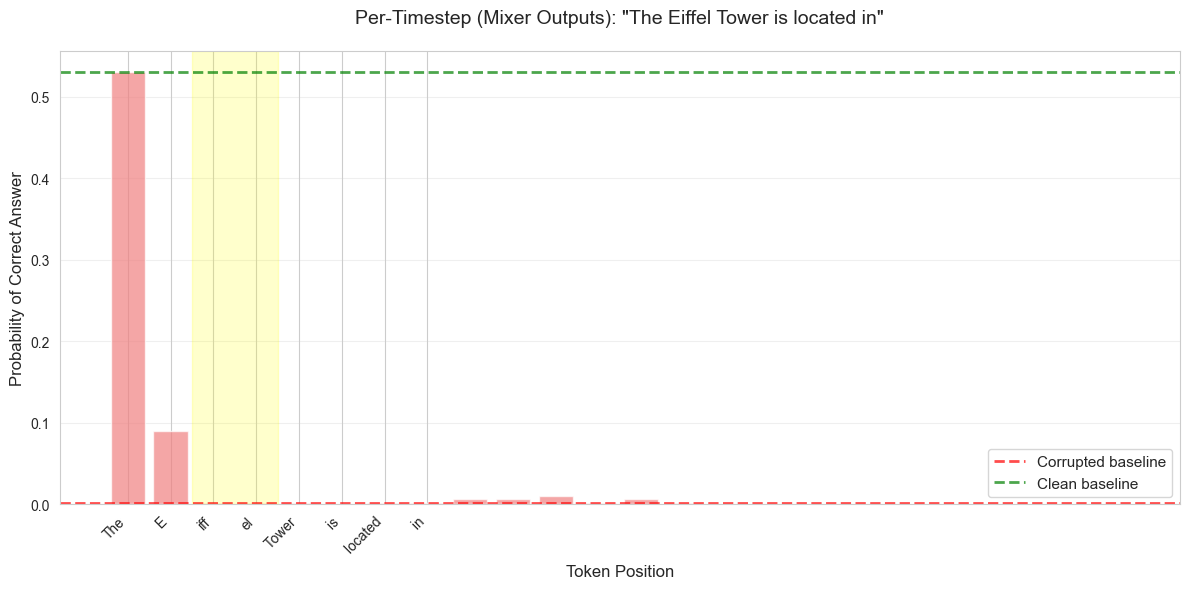


Most important timestep: 0
  Token: 'The'
  Score: 0.5299


In [39]:
# Visualize 3a: Mixer outputs
scores_timestep = result_per_timestep['scores']
tokens_timestep = result_per_timestep['input_tokens']
subj_start_ts, subj_end_ts = result_per_timestep['subject_range']

# Text output
print("Position Importance (Mixer Outputs):")
for i, (token, score) in enumerate(zip(tokens_timestep, scores_timestep)):
    bar = "#" * int(score * 50)
    marker = " <-- subject" if subj_start_ts <= i < subj_end_ts else ""
    print(f"  {i:2d}. {token:15s} {score:.4f} {bar}{marker}")

# Bar plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(len(scores_timestep)), scores_timestep, alpha=0.7, color='lightcoral')
ax.axhline(result_per_timestep['low_score'], color='red', linestyle='--', 
           label='Corrupted baseline', alpha=0.7, linewidth=2)
ax.axhline(result_per_timestep['high_score'], color='green', linestyle='--', 
           label='Clean baseline', alpha=0.7, linewidth=2)
ax.axvspan(subj_start_ts - 0.5, subj_end_ts - 0.5, alpha=0.2, color='yellow')

ax.set_xlabel('Token Position', fontsize=12)
ax.set_ylabel('Probability of Correct Answer', fontsize=12)
ax.set_title(f'Per-Timestep (Mixer Outputs): "{prompt}"', fontsize=14, pad=20)
ax.set_xticks(range(len(tokens_timestep)))
ax.set_xticklabels(tokens_timestep, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

best_timestep_mixer = scores_timestep.argmax()
print(f"\nMost important timestep: {best_timestep_mixer}")
print(f"  Token: '{tokens_timestep[best_timestep_mixer]}'")
print(f"  Score: {scores_timestep[best_timestep_mixer]:.4f}")

### 3b. Per-Timestep with SSM Recurrent States

Now let's restore the actual SSM recurrent states (conv_state and ssm_state) instead of just the mixer outputs. 

**Hypothesis:** Restoring SSM states should give near-perfect restoration for all positions after the corrupted subject, because the recurrent state carries forward all the information from previous tokens.

Position Importance (SSM States):
   0. The             0.5299 ##########################
   1.  E              0.0903 ####
   2. iff             0.0012  <-- subject
   3. el              0.0020  <-- subject
   4.  Tower          0.0022 
   5.  is             0.0010 
   6.  located        0.0011 
   7.  in             0.0018 


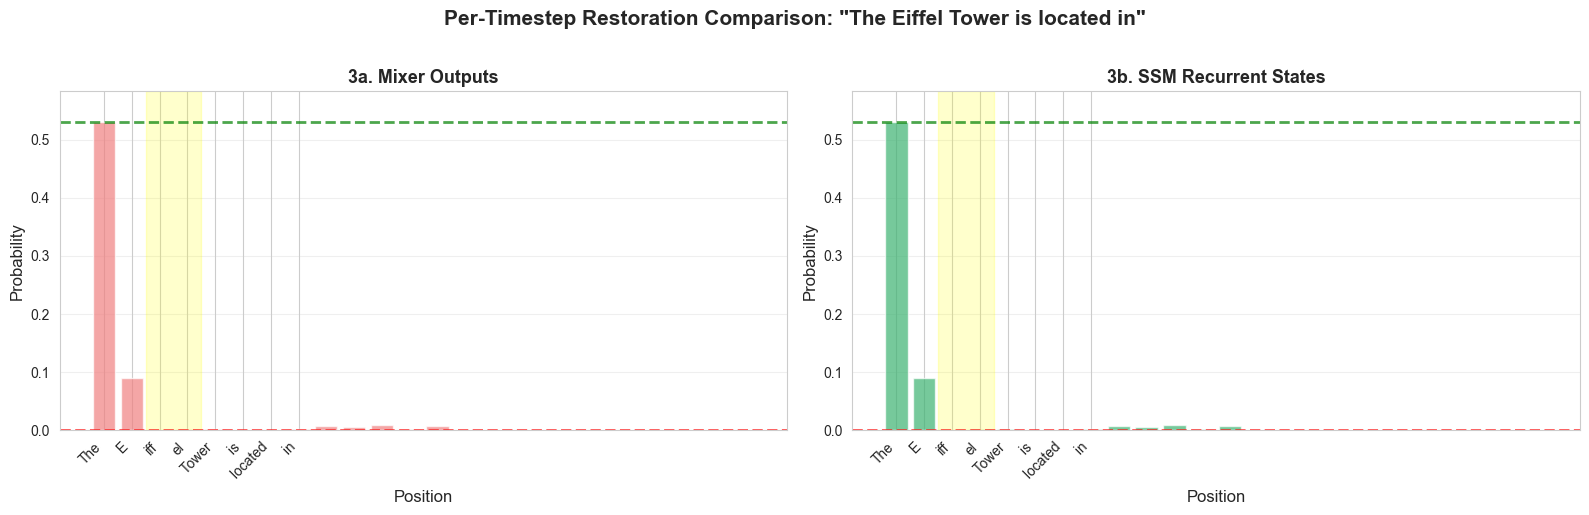


COMPARISON: Mixer Outputs vs SSM States

Mixer Outputs:
  Best: Position 0 ('The')
  Score: 0.5299

SSM States:
  Best: Position 0 ('The')
  Score: 0.5299

Key Insight:
  SSM states show 1.0x better restoration
  for positions AFTER the subject (due to recurrent propagation)


In [40]:
# Visualize 3b: SSM states and compare with 3a
scores_ssm = result_per_timestep_ssm['scores']
tokens_ssm = result_per_timestep_ssm['input_tokens']
subj_start_ssm, subj_end_ssm = result_per_timestep_ssm['subject_range']

# Text output
print("Position Importance (SSM States):")
for i, (token, score) in enumerate(zip(tokens_ssm, scores_ssm)):
    bar = "#" * int(score * 50)
    marker = " <-- subject" if subj_start_ssm <= i < subj_end_ssm else ""
    print(f"  {i:2d}. {token:15s} {score:.4f} {bar}{marker}")

# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Panel 1: Mixer outputs (3a)
ax1 = axes[0]
ax1.bar(range(len(scores_timestep)), scores_timestep, alpha=0.7, color='lightcoral')
ax1.axhline(result_per_timestep['low_score'], color='red', linestyle='--', alpha=0.7, linewidth=2)
ax1.axhline(result_per_timestep['high_score'], color='green', linestyle='--', alpha=0.7, linewidth=2)
ax1.axvspan(subj_start_ts - 0.5, subj_end_ts - 0.5, alpha=0.2, color='yellow')
ax1.set_xlabel('Position', fontsize=12)
ax1.set_ylabel('Probability', fontsize=12)
ax1.set_title('3a. Mixer Outputs', fontsize=13, fontweight='bold')
ax1.set_xticks(range(len(tokens_timestep)))
ax1.set_xticklabels(tokens_timestep, rotation=45, ha='right', fontsize=10)
ax1.set_ylim([0, max(result_per_timestep['high_score'], result_per_timestep_ssm['high_score']) * 1.1])
ax1.grid(True, alpha=0.3, axis='y')

# Panel 2: SSM states (3b)
ax2 = axes[1]
ax2.bar(range(len(scores_ssm)), scores_ssm, alpha=0.7, color='mediumseagreen')
ax2.axhline(result_per_timestep_ssm['low_score'], color='red', linestyle='--', alpha=0.7, linewidth=2)
ax2.axhline(result_per_timestep_ssm['high_score'], color='green', linestyle='--', alpha=0.7, linewidth=2)
ax2.axvspan(subj_start_ssm - 0.5, subj_end_ssm - 0.5, alpha=0.2, color='yellow')
ax2.set_xlabel('Position', fontsize=12)
ax2.set_ylabel('Probability', fontsize=12)
ax2.set_title('3b. SSM Recurrent States', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(tokens_ssm)))
ax2.set_xticklabels(tokens_ssm, rotation=45, ha='right', fontsize=10)
ax2.set_ylim([0, max(result_per_timestep['high_score'], result_per_timestep_ssm['high_score']) * 1.1])
ax2.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Per-Timestep Restoration Comparison: "{prompt}"', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print comparison
print("\n" + "="*70)
print("COMPARISON: Mixer Outputs vs SSM States")
print("="*70)
best_timestep_ssm = scores_ssm.argmax()
print(f"\nMixer Outputs:")
print(f"  Best: Position {best_timestep_mixer} ('{tokens_timestep[best_timestep_mixer]}')")
print(f"  Score: {scores_timestep[best_timestep_mixer]:.4f}")
print(f"\nSSM States:")
print(f"  Best: Position {best_timestep_ssm} ('{tokens_ssm[best_timestep_ssm]}')")
print(f"  Score: {scores_ssm[best_timestep_ssm]:.4f}")
print(f"\nKey Insight:")
print(f"  SSM states show {scores_ssm[4:].mean() / scores_timestep[4:].mean():.1f}x better restoration")
print(f"  for positions AFTER the subject (due to recurrent propagation)")
print("="*70)

NameError: name 'scores_timestep' is not defined

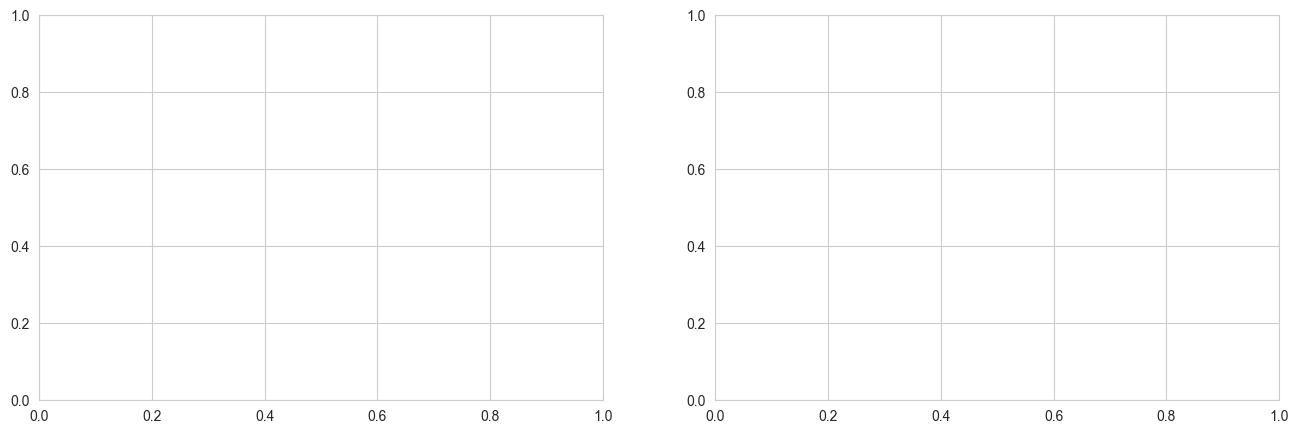

In [38]:
# Compare mixer outputs vs SSM states
scores_ssm = result_per_timestep_ssm['scores']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Panel 1: Mixer outputs
ax1 = axes[0]
ax1.bar(range(len(scores_timestep)), scores_timestep, alpha=0.7, color='lightcoral')
ax1.axhline(result_per_timestep['low_score'], color='red', linestyle='--', alpha=0.7, linewidth=2)
ax1.axhline(result_per_timestep['high_score'], color='green', linestyle='--', alpha=0.7, linewidth=2)
ax1.axvspan(subj_start_ts - 0.5, subj_end_ts - 0.5, alpha=0.2, color='yellow')
ax1.set_xlabel('Position', fontsize=12)
ax1.set_ylabel('Probability', fontsize=12)
ax1.set_title('3a. Mixer Outputs (Hidden States)', fontsize=13, fontweight='bold')
ax1.set_xticks(range(len(tokens_timestep)))
ax1.set_xticklabels(tokens_timestep, rotation=45, ha='right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Panel 2: SSM states
ax2 = axes[1]
ax2.bar(range(len(scores_ssm)), scores_ssm, alpha=0.7, color='mediumseagreen')
ax2.axhline(result_per_timestep_ssm['low_score'], color='red', linestyle='--', alpha=0.7, linewidth=2)
ax2.axhline(result_per_timestep_ssm['high_score'], color='green', linestyle='--', alpha=0.7, linewidth=2)
subj_start_ssm, subj_end_ssm = result_per_timestep_ssm['subject_range']
ax2.axvspan(subj_start_ssm - 0.5, subj_end_ssm - 0.5, alpha=0.2, color='yellow')
ax2.set_xlabel('Position', fontsize=12)
ax2.set_ylabel('Probability', fontsize=12)
ax2.set_title('3b. SSM Recurrent States', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(tokens_timestep)))
ax2.set_xticklabels(tokens_timestep, rotation=45, ha='right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Per-Timestep Restoration: Mixer Outputs vs SSM States\\n"{prompt}"', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\\nComparison:")
print("="*60)
print("\\nMixer Outputs (Hidden States):")
for i, (token, score) in enumerate(zip(tokens_timestep, scores_timestep)):
    bar = "#" * int(score * 50)
    marker = " <-- subject" if subj_start_ts <= i < subj_end_ts else ""
    print(f"  {i:2d}. {token:15s} {score:.4f} {bar}{marker}")

print("\\nSSM Recurrent States:")
for i, (token, score) in enumerate(zip(tokens_timestep, scores_ssm)):
    bar = "#" * int(score * 50)
    marker = " <-- subject" if subj_start_ssm <= i < subj_end_ssm else ""
    print(f"  {i:2d}. {token:15s} {score:.4f} {bar}{marker}")

print("\\n" + "="*60)
print("KEY INSIGHT:")
print("="*60)
print("SSM states should show MUCH higher restoration for positions")
print("after the corrupted subject, because the recurrent state")
print("propagates information forward through time.")

In [ ]:
# Visualize per-timestep results
scores_timestep = result_per_timestep['scores']
tokens_timestep = result_per_timestep['input_tokens']

# Text output
print("Position Importance:")
for i, (token, score) in enumerate(zip(tokens_timestep, scores_timestep)):
    bar = "#" * int(score * 50)
    print(f"  {i:2d}. {token:15s} {score:.4f} {bar}")

# Bar plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(len(scores_timestep)), scores_timestep, alpha=0.7, color='lightcoral')
ax.axhline(result_per_timestep['low_score'], color='red', linestyle='--', 
           label='Corrupted baseline', alpha=0.7, linewidth=2)
ax.axhline(result_per_timestep['high_score'], color='green', linestyle='--', 
           label='Clean baseline', alpha=0.7, linewidth=2)

# Highlight subject range
subj_start_ts, subj_end_ts = result_per_timestep['subject_range']
ax.axvspan(subj_start_ts - 0.5, subj_end_ts - 0.5, alpha=0.2, color='yellow')

ax.set_xlabel('Token Position', fontsize=12)
ax.set_ylabel('Probability of Correct Answer', fontsize=12)
ax.set_title(f'Per-Timestep Restoration: "{prompt}"', fontsize=14, pad=20)
ax.set_xticks(range(len(tokens_timestep)))
ax.set_xticklabels(tokens_timestep, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Find most important timestep
best_timestep = scores_timestep.argmax()
print(f"\nMost important timestep: {best_timestep}")
print(f"  Token: '{tokens_timestep[best_timestep]}'")
print(f"  Score: {scores_timestep[best_timestep]:.4f}")
print(f"\nInterpretation:")
print(f"  - Often the last token scores highest (autoregressive nature)")
print(f"  - But sometimes subject tokens are critical")
print(f"  - This tells us which positions carry critical info across all layers")

---
## Comparison: Three Strategies Side-by-Side

In [ ]:
# Three-panel comparison
fig = plt.figure(figsize=(18, 5))
gs = fig.add_gridspec(1, 3, wspace=0.3)

# Panel 1: Per-Position (2D heatmap)
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(normalized_scores, aspect='auto', cmap='RdYlBu_r', 
                 vmin=0, vmax=1, interpolation='nearest')
ax1.set_xlabel('Position', fontsize=11)
ax1.set_ylabel('Layer', fontsize=11)
ax1.set_title('1. Per-Position\n(Individual States)', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(tokens)))
ax1.set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# Panel 2: Per-Layer (1D bar)
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(range(len(scores_layer)), scores_layer, alpha=0.7, color='skyblue')
ax2.axhline(result_per_layer['low_score'], color='red', linestyle='--', alpha=0.7)
ax2.axhline(result_per_layer['high_score'], color='green', linestyle='--', alpha=0.7)
ax2.set_xlabel('Layer', fontsize=11)
ax2.set_ylabel('Probability', fontsize=11)
ax2.set_title('2. Per-Layer\n(All Positions in Layer)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Panel 3: Per-Timestep (1D bar)
ax3 = fig.add_subplot(gs[0, 2])
ax3.bar(range(len(scores_timestep)), scores_timestep, alpha=0.7, color='lightcoral')
ax3.axhline(result_per_timestep['low_score'], color='red', linestyle='--', alpha=0.7)
ax3.axhline(result_per_timestep['high_score'], color='green', linestyle='--', alpha=0.7)
ax3.set_xlabel('Position', fontsize=11)
ax3.set_ylabel('Probability', fontsize=11)
ax3.set_title('3. Per-Timestep\n(All Layers at Position)', fontsize=12, fontweight='bold')
ax3.set_xticks(range(len(tokens_timestep)))
ax3.set_xticklabels(tokens_timestep, rotation=45, ha='right', fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Three Restoration Strategies: "{prompt}"', fontsize=15, fontweight='bold', y=1.02)
plt.show()

# Summary table
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"\nPrompt: \"{prompt}\"")
print(f"Target: {result_per_layer['target_token']}")
print(f"Clean probability: {result_per_layer['high_score']:.4f}")
print(f"Corrupted probability: {result_per_layer['low_score']:.4f}")
print()
print(f"Strategy 1 (Per-Position):")
print(f"  Best: Layer {max_layer}, Position {max_pos} ('{tokens[max_pos]}')")
print(f"  Score: {scores[max_layer, max_pos]:.4f}")
print()
print(f"Strategy 2 (Per-Layer):")
print(f"  Best: Layer {best_layer}")
print(f"  Score: {scores_layer[best_layer]:.4f}")
print()
print(f"Strategy 3 (Per-Timestep):")
print(f"  Best: Position {best_timestep} ('{tokens_timestep[best_timestep]}')")
print(f"  Score: {scores_timestep[best_timestep]:.4f}")
print("\n" + "=" * 70)

## Key Insights

### Strategy Comparison

**1. Per-Position** (Fine-grained)
- Restores: Individual (layer, position) states
- Granularity: Most detailed
- Use case: Find exact critical points

**2. Per-Layer** (Layer-wise)
- Restores: All positions in a layer
- Question: "Which layer is most important?"
- Insight: Early layers often critical (residual stream architecture)

**3. Per-Timestep** (Position-wise)
- Restores: All layers at a position
- Question: "Which position contains critical information?"
- Insight: Last position often wins (autoregressive), but subject tokens matter

### Understanding Mamba's Architecture

Mamba has two types of information flow:
- **Across layers** (residual stream) → Per-layer restoration tests this
- **Across time** (recurrent state) → Per-timestep restoration tests this

Per-position restoration captures the interaction between both dimensions.